In [1]:
import pandas as pd
import json
from nltk.stem.porter import PorterStemmer
import nltk
from bs4 import BeautifulSoup
from nltk.corpus import stopwords
import re
from sklearn.feature_extraction.text import TfidfTransformer, TfidfVectorizer, CountVectorizer, TfidfVectorizer
import numpy as np

from sklearn.linear_model import LogisticRegression

from sklearn.decomposition import PCA, TruncatedSVD, KernelPCA

import matplotlib.pyplot as plt

np.set_printoptions(precision=4)

from sklearn.metrics import *
from mlxtend import plotting 

%matplotlib inline 

In [2]:
print(nltk.__version__)

3.2.4


In [7]:
!head -n 1 data/imdb-comments.json

{"label":"test","sentiment":"pos","name":"0_10.txt","content":"I went and saw this movie last night after being coaxed to by a few friends of mine. I'll admit that I was reluctant to see it because from what I knew of Ashton Kutcher he was only able to do comedy. I was wrong. Kutcher played the character of Jake Fischer very well, and Kevin Costner played Ben Randall with such professionalism. The sign of a good movie is that it can toy with our emotions. This one did exactly that. The entire theater (which was sold out) was overcome by laughter during the first half of the movie, and were moved to tears during the second half. While exiting the theater I not only saw many women in tears, but many full grown men as well, trying desperately not to let anyone see them crying. This movie was great, and I suggest that you go see it before you judge."}


In [3]:
data = []
with open("data/imdb-comments.json", "r") as f:
    for l in f.readlines():
        data.append(json.loads(l))    

In [5]:
comments = pd.DataFrame.from_dict(data)
comments.sample(25)

,content,label,name,sentiment
30737,"Personally, I think that the film was done ver...",train,3914_10.txt,pos
9760,I think this movie is underrated. To me it fel...,test,7535_10.txt,pos
37120,"Yokai Monsters: Spook Warfare (Yokai daisenso,...",train,965_10.txt,pos
5364,Blue Planet... Wow... Where do I begin? The ye...,test,3579_8.txt,pos
42073,"I was lying on my bed, with a really bad cold ...",train,2867_1.txt,neg
21099,"Charlie (George ""Norm"" Wendt) and Rhonda (""Jus...",test,6490_1.txt,neg
19142,Against my own better judgment I went to see t...,test,4729_1.txt,neg
40812,The Twilight Zone has achieved a certain mytho...,train,1731_3.txt,neg
11913,I just took my 11 year old daughter and 8 year...,test,9473_9.txt,pos
13906,I see that C. Thomas Howell has appeared in ma...,test,11266_2.txt,neg


In [8]:
comments.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 4 columns):
content      50000 non-null object
label        50000 non-null object
name         50000 non-null object
sentiment    50000 non-null object
dtypes: object(4)
memory usage: 1.5+ MB


In [9]:
comments.label.value_counts()

train    25000
test     25000
Name: label, dtype: int64

In [15]:
comments.groupby(["label", "sentiment"]).content.count().unstack()

sentiment,neg,pos
label,,
test,12500,12500
train,12500,12500


In [16]:
v = list(comments["content"].sample(1))[0]
v

"The Ascent (1977) <br /><br />Larisa Shepitko is a name very few are familiar with. Her bright career as a director only lasted a single decade, ended abruptly by a tragic car accident. Despite her short career, she however managed to create some of the best Soviet films of her time. Her last film, The Ascent, is widely regarded as one of the finest Soviet films of the 1970s. Nevertheless, her work remained in obscurity throughout the years that followed, usually only available on rare and poor copies on video. That has now changed thanks to the folks at Criterion. They've released two of Shepitko's best works through their Eclipse department - Wings, and her penultimate masterpiece The Ascent.<br /><br />Set during the darkest days of WWII in snowy rural Russia, two partisans trudge their way across the land in search of food after their party is attacked by Nazi patrols. They're originally only to go to a nearby farm, but when they arrive they find it razed by the Germans. Not wanti

In [17]:
def preprocess(text):
    text = BeautifulSoup(text, "html5lib").text.lower() #removed html tags
    text = re.sub("[\W]+", " ", text)
    return text

preprocess(v)

'the ascent 1977 larisa shepitko is a name very few are familiar with her bright career as a director only lasted a single decade ended abruptly by a tragic car accident despite her short career she however managed to create some of the best soviet films of her time her last film the ascent is widely regarded as one of the finest soviet films of the 1970s nevertheless her work remained in obscurity throughout the years that followed usually only available on rare and poor copies on video that has now changed thanks to the folks at criterion they ve released two of shepitko s best works through their eclipse department wings and her penultimate masterpiece the ascent set during the darkest days of wwii in snowy rural russia two partisans trudge their way across the land in search of food after their party is attacked by nazi patrols they re originally only to go to a nearby farm but when they arrive they find it razed by the germans not wanting to return empty handed they continue on de

In [18]:
comments["content"] = comments["content"].apply(preprocess)

In [19]:
comments_train = comments[comments["label"] == "train"]
comments_train.sample(10)

,content,label,name,sentiment
38869,it is so sad even though this was shot with fi...,train,11232_1.txt,neg
30029,this film is fantastic as it explores storytel...,train,3277_9.txt,pos
32408,cary grant douglas fairbanks jr and victor mcl...,train,5418_10.txt,pos
27777,contains spoilers due to me having to describ...,train,124_10.txt,pos
34110,on the day of the california presidential prim...,train,6950_8.txt,pos
33821,mystery men is one of those movies that gets f...,train,6690_10.txt,pos
25213,this is the who at their most powerful althoug...,train,10192_8.txt,pos
29306,lion king 1 1 2 is the funniest non theatrica...,train,2626_8.txt,pos
42138,after reading several good reviews as well as ...,train,2925_1.txt,neg
30927,if you were born around the time this movie wa...,train,4085_10.txt,pos


In [20]:
comments_test = comments[comments["label"] == "test"]
comments_test.sample(10)

,content,label,name,sentiment
19795,get shorty was an excellent film it was funny ...,test,5316_2.txt,neg
188,distributor goodtimes home video plot a pretty...,test,1016_7.txt,pos
22563,this film made me so angry because of its stup...,test,7808_1.txt,neg
11049,so many early british sound films that i ve se...,test,8696_9.txt,pos
6417,murder over new york is an entertaining entry...,test,4526_7.txt,pos
12699,director fabio barreto got a strange academy n...,test,1017_1.txt,neg
15007,a genuinely odd surreal jumble of visual ideas...,test,12257_3.txt,neg
21307,ordinarily i wouldn t waste the time on review...,test,6678_1.txt,neg
884,in one of the more under seen films of the lat...,test,10797_10.txt,pos
23580,drivel utter junk the writers must not have re...,test,8723_1.txt,neg


In [12]:
X_train = comments_train["content"].values
y_train = comments_train["sentiment"].apply(lambda v: 1 if v == "pos" else 0)

In [13]:
X_test = comments_test["content"].values
y_test = comments_test["sentiment"].apply(lambda v: 1 if v == "pos" else 0)

In [15]:
# http://snowball.tartarus.org/algorithms/porter/stemmer.html
porter = PorterStemmer()
for s in "revival allowance inference relational".split():
    print(s, porter.stem(s))

revival reviv
allowance allow
inference infer
relational relat


In [ ]:
nltk.download()

showing info https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/index.xml


In [22]:
porter = PorterStemmer()
stop = stopwords.words("english")
stemming_errors = []

def stemmer(text):
    #stems = [porter.stem(word) for word in text.split() if len(word) > 2]
    stems = []
    for word in text.split():
        try:
            stems.append(porter.stem(word)) 
            # Error stemming "oed". Issue in v 3.2.2 https://github.com/nltk/nltk/issues/1581
        except:
            stemming_errors.append(word)
    return stems

stemmer("runners like running and thus they run")

LookupError: 
**********************************************************************
  Resource 'corpora/stopwords' not found.  Please use the NLTK
  Downloader to obtain the resource:  >>> nltk.download()
  Searched in:
    - '/Users/abulbasar/nltk_data'
    - '/usr/share/nltk_data'
    - '/usr/local/share/nltk_data'
    - '/usr/lib/nltk_data'
    - '/usr/local/lib/nltk_data'
**********************************************************************

In [21]:
tfidf = TfidfVectorizer(tokenizer=porter.stem, ngram_range=(1, 1), stop_words = stop)

docs = ["The sun is shining", "The weather is sweet", "the sun is shining and the weather is sweet"]
print("TFIDF matrix: \n", tfidf.fit_transform(docs).toarray())
print("Vocabulary: ", tfidf.vocabulary_)

NameError: name 'porter' is not defined

In [18]:
X_train_tfidf = tfidf.fit_transform(X_train)

In [19]:
print("Stemming errors", stemming_errors)

Stemming errors ['oed']


In [20]:
X_test_tfidf = tfidf.transform(X_test)

In [39]:
pca = TruncatedSVD(n_components=2, random_state=0, n_iter=100)
X_train_pca = pca.fit_transform(X_train_tfidf)

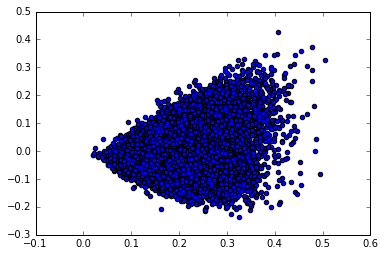

In [40]:
plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1])

In [32]:
X_train_pca.shape

(25000, 2)

In [41]:
pca.explained_variance_ratio_

array([ 0.0043,  0.0058])

In [23]:
lgx = LogisticRegression(C = 10, random_state = 0)
lgx.fit(X_train_tfidf, y_train)

LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=0, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [24]:
y_test_pred = lgx.predict(X_test_tfidf)

In [25]:
print("accuracy: ", accuracy_score(y_test, y_test_pred), 
      "\nprecision: ", precision_score(y_test, y_test_pred), 
      "\nrecall: ", recall_score(y_test, y_test_pred), 
      "\nf1:", f1_score(y_test, y_test_pred))

accuracy:  0.87232 
precision:  0.881475409836 
recall:  0.86032 
f1: 0.870769230769


(<matplotlib.figure.Figure at 0x105f91c18>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1171800b8>)

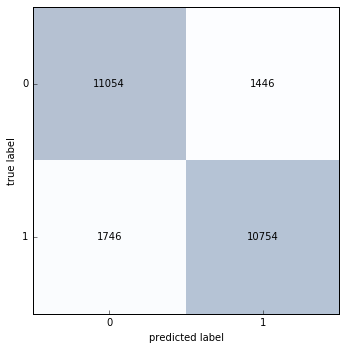

In [26]:
plotting.plot_confusion_matrix(confusion_matrix(y_test, y_test_pred), figsize=(5.5, 5.5))

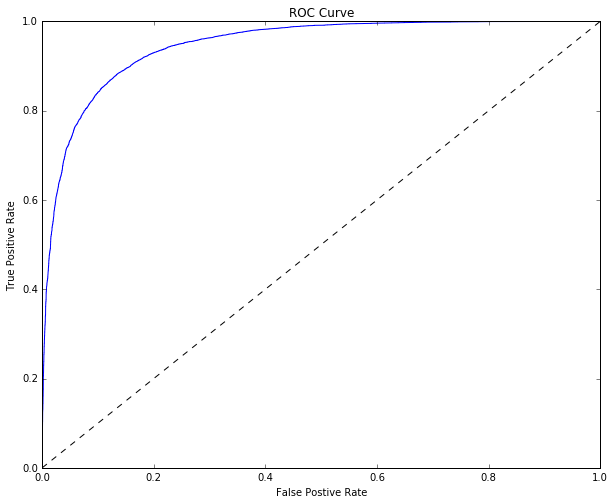

In [27]:
fpr, tpr, thresholds = roc_curve(y_test, lgx.predict_proba(X_test_tfidf)[:, [1]])

plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr)
plt.ylim(0, 1)
plt.xlim(0, 1)
plt.plot([0,1], [0,1], ls = "--", color = "k")
plt.xlabel("False Postive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")